In [1]:
import os
from pathlib import Path
from dataclasses import dataclass

In [2]:
%pwd

'/home/priyanshu1303d/Projects/Heart_Segmentation/research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'/home/priyanshu1303d/Projects/Heart_Segmentation'

# Step 1: Config for training

In [5]:
@dataclass(frozen=True)
class ModelTrainingConfig:
    root_dir : Path
    images_dir : Path
    labels_dir : Path
    model_save_path: Path
    params_learning_rate : float
    params_epochs : int
    params_batch_size : int
    params_weight_decay : float
    params_dropout_rate : float


# Step 2: Update ConfigurationManager

In [6]:
from Heart_Segmentation.constants import *
from Heart_Segmentation.utils.common import read_yaml , create_directories , logger

In [7]:
class ConfigurationManager:
    def __init__(self , config_filepath = CONFIG_FILE_PATH , params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])

    def get_Model_training_config(self) -> ModelTrainingConfig:

        config = self.config.model_training 
        create_directories([config.root_dir ])

        model_training_config = ModelTrainingConfig(
            root_dir = Path(config.root_dir),
            images_dir= Path(config.images_dir),
            labels_dir= Path(config.labels_dir),
            model_save_path= Path(config.model_save_path),
            params_batch_size= self.params.BATCH_SIZE,
            params_dropout_rate= self.params.DROPOUT_RATE,
            params_epochs= self.params.EPOCHS,
            params_learning_rate= self.params.LEARNING_RATE,
            params_weight_decay= self.params.WEIGHT_DECAY
        )

        return model_training_config

# Step 3: Dataset class

In [8]:
from torch.utils.data import Dataset , DataLoader
import nibabel as nib
import torch

In [9]:
class HeartSegmentationDataset(Dataset):
    def __init__(self, images_dir : str , labels_dir : str):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.nii.gz')]
        logger.info(f"Found {len(self.image_files)} files in {images_dir}")
        if not self.image_files:
            raise ValueError(f"No .nii.gz files found in {images_dir}")

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        label_path = os.path.join(self.labels_dir, image_file)
        
        image = nib.load(image_path).get_fdata()
        label = nib.load(label_path).get_fdata()
        
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # [1, 128, 128, 64]
        label = torch.tensor(label, dtype=torch.long)  # [128, 128, 64]
        
        return image, label, image_file

    

# Step 4: Training class

In [10]:
import torch.nn as nn
from monai.networks.nets import UNet
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [13]:
class ModelTraining:
    def __init__(self , config : ModelTrainingConfig ):
        super().__init__()

        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 3D U-Net from MONAI (not pretrained, simpler than SMP's ResNet)
        self.model = UNet(
            spatial_dims=3,  # 3D data
            in_channels=1,   # Grayscale
            out_channels=3,  # 3 classes (adjust if needed)
            channels=(16, 32, 64, 128, 256),  # Feature maps per layer
            strides=(2, 2, 2, 2),  # Downsampling steps
            num_res_units=2  # Residual units
        ).to(self.device)

        #loss function and optimizer init
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters() , lr = self.config.params_learning_rate , weight_decay=self.config.params_weight_decay)

        #DataLoader object
        dataset = HeartSegmentationDataset(self.config.images_dir, self.config.labels_dir)
        self.dataloader = DataLoader(dataset , batch_size=self.config.params_batch_size, shuffle=False , pin_memory= True)


    def train(self):
        logger.info(f"-------------Started Training----------")
        self.model.train()
        running_loss = 0.0  # Initialized here
        
        for epoch in range(self.config.params_epochs):
            for images, labels, _ in self.dataloader:
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                y_pred = self.model(images)  # [batch_size, classes, 128, 128, 64]
                loss = self.loss_function(y_pred, labels)

                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item()
            
            avg_loss = running_loss / len(self.dataloader)
            logger.info(f"Epoch [{epoch+1}/{self.config.params_epochs}], Loss: {avg_loss:.4f}")
        
        # Save the model
        torch.save(self.model.state_dict(), self.config.model_save_path)
        logger.info(f"Model saved to {self.config.model_save_path}")

    def predict(self, image: torch.Tensor) -> np.ndarray:
        self.model.eval()
        with torch.no_grad():
            image = image.unsqueeze(0).to(self.device)  # Add batch dimension
            output = self.model(image)
            pred = torch.argmax(output, dim=1).cpu().numpy()
        return pred[0]

    def visualize_predictions(self, num_samples: int = 3):
        dataset = HeartSegmentationDataset(self.config.images_dir, self.config.labels_dir)
        samples = [dataset[i] for i in range(min(num_samples, len(dataset)))]
        
        for image, label, filename in samples:
            pred = self.predict(image)
            
            slice_idx = image.shape[-1] // 2
            image_slice = image[0, :, :, slice_idx].numpy()
            label_slice = label[:, :, slice_idx].numpy()
            pred_slice = pred[:, :, slice_idx]
            
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(image_slice, cmap="gray")
            plt.title(f"Image: {filename}")
            plt.axis("off")
            plt.subplot(1, 3, 2)
            plt.imshow(image_slice, cmap="gray")
            plt.imshow(label_slice, cmap="jet", alpha=0.5)
            plt.title("Ground Truth")
            plt.axis("off")
            plt.subplot(1, 3, 3)
            plt.imshow(image_slice, cmap="gray")
            plt.imshow(pred_slice, cmap="jet", alpha=0.5)
            plt.title("Prediction")
            plt.axis("off")
            plt.tight_layout()
            plt.show()


[2025-03-26 23:19:22,983: INFO: common : yaml file: config/config.yaml loaded successfully]
[2025-03-26 23:19:22,986: INFO: common : yaml file: params.yaml loaded successfully]
[2025-03-26 23:19:22,987: INFO: common : created directory at: artifacts]
[2025-03-26 23:19:22,988: INFO: common : created directory at: artifacts/model_training]


[2025-03-26 23:19:23,210: INFO: 3040450924 : Found 20 files in artifacts/data_preprocessing/preprocessed]
[2025-03-26 23:19:23,211: INFO: 785117075 : -------------Started Training----------]
[2025-03-26 23:19:26,961: INFO: 785117075 : Epoch [1/10], Loss: 1.1194]
[2025-03-26 23:19:30,468: INFO: 785117075 : Epoch [2/10], Loss: 1.9475]
[2025-03-26 23:19:33,782: INFO: 785117075 : Epoch [3/10], Loss: 2.5888]
[2025-03-26 23:19:37,065: INFO: 785117075 : Epoch [4/10], Loss: 3.0751]
[2025-03-26 23:19:40,334: INFO: 785117075 : Epoch [5/10], Loss: 3.4074]
[2025-03-26 23:19:43,589: INFO: 785117075 : Epoch [6/10], Loss: 3.6173]
[2025-03-26 23:19:46,873: INFO: 785117075 : Epoch [7/10], Loss: 3.7502]
[2025-03-26 23:19:50,163: INFO: 785117075 : Epoch [8/10], Loss: 3.8400]
[2025-03-26 23:19:53,462: INFO: 785117075 : Epoch [9/10], Loss: 3.9055]
[2025-03-26 23:19:56,784: INFO: 785117075 : Epoch [10/10], Loss: 3.9582]
[2025-03-26 23:19:56,815: INFO: 785117075 : Model saved to artifacts/model_training/unet

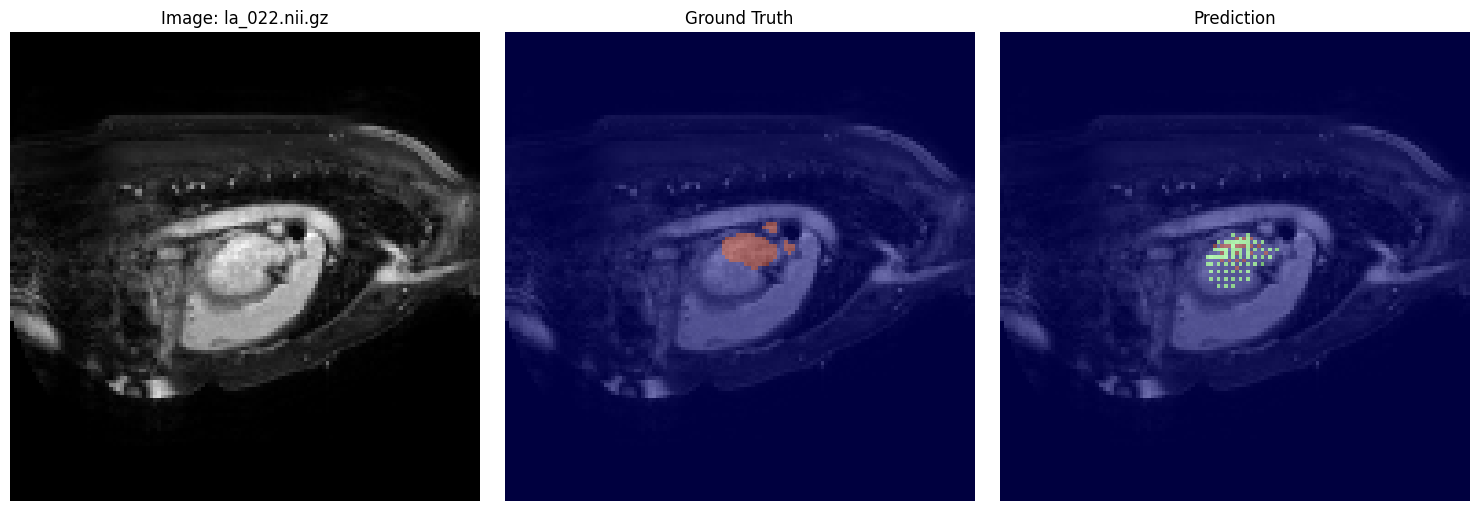

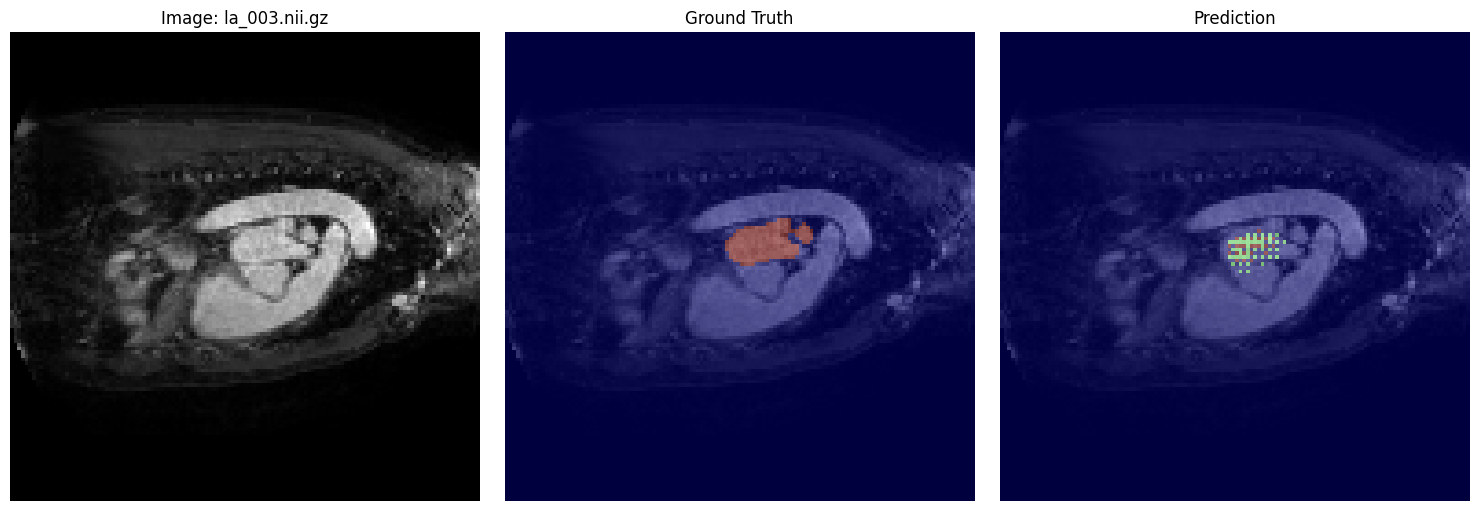

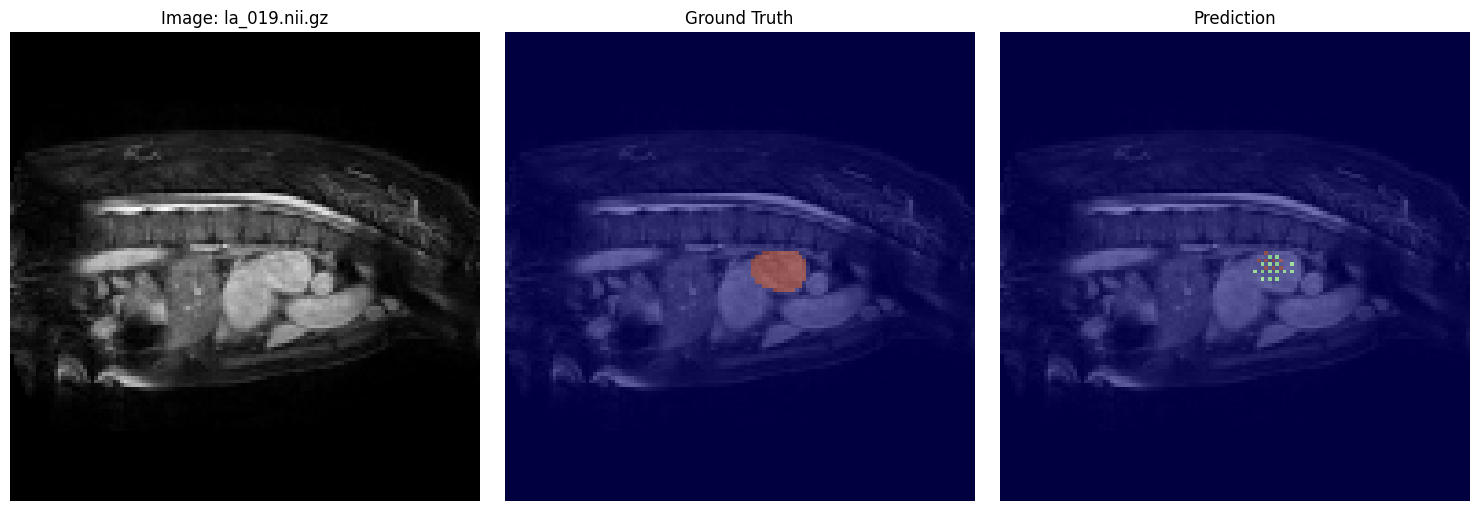

In [14]:
try:
    config = ConfigurationManager()
    get_model_trainig_config = config.get_Model_training_config()
    model_training = ModelTraining(get_model_trainig_config)
    model_training.train()
    logger.info("Visualizing predictions...")
    model_training.visualize_predictions(num_samples=3)
except Exception as e:
    logger.error(f"Error: {str(e)}")
    raise e